# **Skin Segmentation - Grupo 10**

El conjunto de datos de piel se recopila mediante el muestreo aleatorio de valores B, G, R de imágenes de rostros de diversos grupos de edad (jóvenes, mediana edad y ancianos), grupos raciales (blanco, negro y asiático) y géneros, obtenidas de las bases de datos FERET y PAL. El tamaño total de la muestra de aprendizaje es de 245,057; de los cuales 50,859 son muestras de piel y 194,198 son muestras de no piel.

Base de datos de imágenes en color FERET: http://face.nist.gov/colorferet/request.html
Base de datos de rostros PAL del Laboratorio de Envejecimiento Productivo, Universidad de Texas en Dallas: https://pal.utdallas.edu/facedb/.

Bhatt, R. & Dhall, A. (2009). Skin Segmentation [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5T30C.

## **Importar Bibliotecas**

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from ucimlrepo import fetch_ucirepo

## **Conexión a la base de datos**

In [99]:
!pip install ucimlrepo

In [100]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
skin_segmentation = fetch_ucirepo(id=229)

# data (as pandas dataframes)
X = skin_segmentation.data.features
y = skin_segmentation.data.targets

# metadata
print(skin_segmentation.metadata)

# variable information
print(skin_segmentation.variables)


{'uci_id': 229, 'name': 'Skin Segmentation', 'repository_url': 'https://archive.ics.uci.edu/dataset/229/skin+segmentation', 'data_url': 'https://archive.ics.uci.edu/static/public/229/data.csv', 'abstract': 'The Skin Segmentation dataset is constructed over B, G, R color space. Skin and Nonskin dataset is generated using skin textures from face images of diversity of age, gender, and race people.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Univariate'], 'num_instances': 245057, 'num_features': 3, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Tue Apr 09 2024', 'dataset_doi': '10.24432/C5T30C', 'creators': ['Rajen Bhatt', 'Abhinav Dhall'], 'intro_paper': None, 'additional_info': {'summary': 'The skin dataset is collected by randomly sampling B,G,R values from face images of various age groups (young, midd

## **Ver datos**

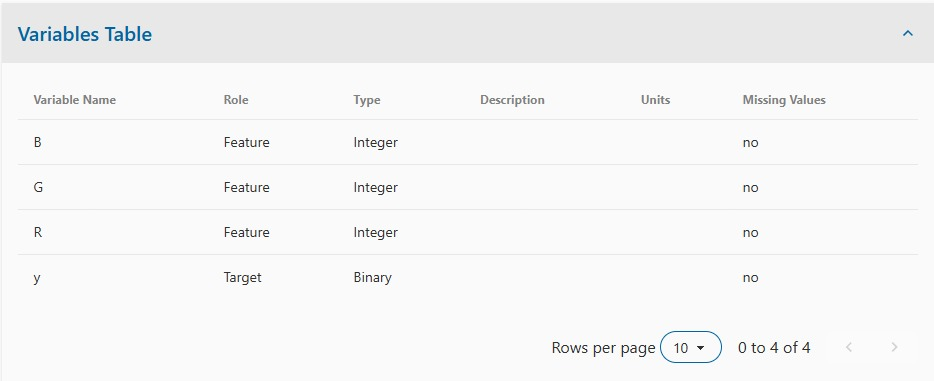


# Se validan los valores unicos de los valores y, se cambian a binarios debido a que son 1 y 2:

In [ ]:
print(X.head())

print(y.head())

print(y.iloc[:, 0].unique())
y = y.iloc[:, 0].map({1: 0, 2: 1})


    B   G    R
0  74  85  123
1  73  84  122
2  72  83  121
3  70  81  119
4  70  81  119
   y
0  1
1  1
2  1
3  1
4  1
[1 2]


In [102]:
# Datos Faltantes

print("Datos faltantes en X:")
print(X.isnull().sum())

print("\nDatos faltantes en y:")
print(y.isnull().sum())

Datos faltantes en X:
B    0
G    0
R    0
dtype: int64

Datos faltantes en y:
0


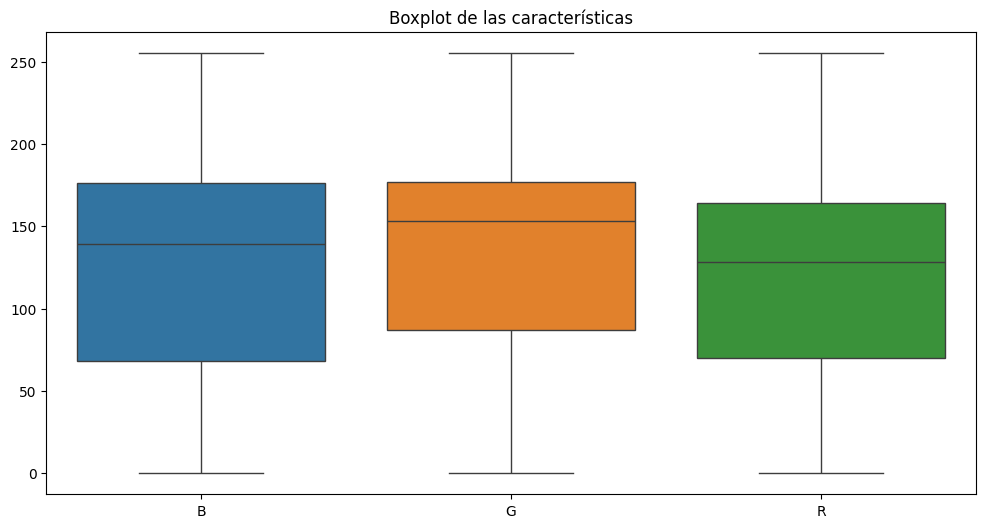

In [103]:
# Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.title("Boxplot de las características")
plt.show()

In [104]:
# Balanceo del modelo

class_distribution = y.value_counts()
print("Distribución de clases:")
print(class_distribution)

class_percentage = y.value_counts(normalize=True) * 100
print("\nPorcentaje de clases:")
print(class_percentage)



Distribución de clases:
y
1    194198
0     50859
Name: count, dtype: int64

Porcentaje de clases:
y
1    79.246053
0    20.753947
Name: proportion, dtype: float64


## **Crear y Entrenar el Modelo - | Random Subsampling |**

In [105]:
# Datos de entrenamiento y prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57)

# Modelo de regresión logística
model = LogisticRegression(max_iter=1000, class_weight='balanced') # Se balancea el modelo

# Entrenar modelo
model.fit(X_train, y_train)

# Predecir en conjunto de prueba
y_pred = model.predict(X_test)

### **Evaluación del modelo**

In [106]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusión:\n{conf_matrix}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred)
print(f"Sensitivity (Recall): {sensitivity:.4f}")

# Specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")

Matriz de Confusión:
[[14607   593]
 [ 4740 53578]]
Accuracy: 0.9275
Sensitivity (Recall): 0.9187
Specificity: 0.9610
Precision: 0.9891
F1-score: 0.9526


## **Modelo con N-FOLDS**

In [115]:
# Configurar el esquema de validación cruzada con N=10
# (El conjunto se divide en 10 partes, se entrena el modelo 9 veces con diferentes combinaciones y se evalúa en la partición restante)
kf = KFold(n_splits=10, shuffle=True, random_state=57)

# Listas para almacenar las métricas de cada iteración
accuracies = []
sensitivities = []
specificities = []
precisions = []
f1_scores = []

conf_matrix_accumulated = np.zeros((2, 2))

# Validación cruzada
for train_index, test_index in kf.split(X): # 10 Iteraciones

    # Dividir Datos de entrenamiento y prueba
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modelo de regresión logística
    model = LogisticRegression(max_iter=1000)

    # Entrenar modelo
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Métricas
    accuracies.append(accuracy_score(y_test, y_pred))
    sensitivities.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificities.append(tn / (tn + fp))

    #conf_matrix = confusion_matrix(y_test, y_pred)
    #print("Matriz de Confusión:")
    #print(conf_matrix)

    #print(f"Accuracy: {accuracy:.4f}")
    #print(f"Sensitivity (Recall): {sensitivity:.4f}")
    #print(f"Specificity: {specificity:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"F1-score: {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_accumulated += conf_matrix

# Métricas (Promedio)

conf_matrix_avg = np.round(conf_matrix_accumulated / 10).astype(int)
print("\nMatriz de Confusión Promedio:")
print(conf_matrix_avg)

print("\nMétricas promedio en N-Folds Validation (N=10):")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Sensitivity (Recall): {np.mean(sensitivities):.4f}")
print(f"Specificity: {np.mean(specificities):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f}")


Matriz de Confusión Promedio:
[[ 4188   897]
 [ 1092 18327]]

Métricas promedio en N-Folds Validation (N=10):
Accuracy: 0.9188
Sensitivity (Recall): 0.9437
Specificity: 0.8236
Precision: 0.9533
F1-score: 0.9485


## **Modelo con Sub-Sampling (10 veces)**

In [114]:
# Listas para almacenar las métricas de cada iteración
accuracies_rs = []
sensitivities_rs = []
specificities_rs = []
precisions_rs = []
f1_scores_rs = []

conf_matrix_accumulated = np.zeros((2, 2))

# Repetir el random subsampling 10 veces
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracies_rs.append(accuracy_score(y_test, y_pred))
    sensitivities_rs.append(recall_score(y_test, y_pred))
    precisions_rs.append(precision_score(y_test, y_pred))
    f1_scores_rs.append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificities_rs.append(tn / (tn + fp))

    #print(f"Accuracy: {accuracy:.4f}")
    #print(f"Sensitivity (Recall): {sensitivity:.4f}")
    #print(f"Specificity: {specificity:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"F1-score: {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_accumulated += conf_matrix


# Métricas (Promedio)

conf_matrix_avg = np.round(conf_matrix_accumulated / 10).astype(int)
print("\nMatriz de Confusión Promedio:")
print(conf_matrix_avg)

print("\nMétricas promedio en Random Subsampling (10 repeticiones):")
print(f"Accuracy: {np.mean(accuracies_rs):.4f}")
print(f"Sensitivity (Recall): {np.mean(sensitivities_rs):.4f}")
print(f"Specificity: {np.mean(specificities_rs):.4f}")
print(f"Precision: {np.mean(precisions_rs):.4f}")
print(f"F1-score: {np.mean(f1_scores_rs):.4f}")


Matriz de Confusión Promedio:
[[12572  2696]
 [ 3281 54968]]

Métricas promedio en Random Subsampling (10 repeticiones):
Accuracy: 0.9187
Sensitivity (Recall): 0.9437
Specificity: 0.8234
Precision: 0.9532
F1-score: 0.9484


En todos los casos, el modelo tiene altos indicadores:


**Accuracy:** La mayoría de las instancias. El recall es alto, lo que significa que el modelo identifica correctamente la mayoría de los casos positivos.

**Recall:** El modelo identifica correctamente la mayoría de los casos positivos.

**Especificidad:** El modelo es excelente para identificar la clase negativa.

**La precisión:** Hay muy pocos falsos positivos.

**F1-score:** Hay un buen equilibrio entre precisión y recall.



- El modelo con sub-sampling tiene un excelente desempeño en la identificación de ambas clases, con un alto recall y precisión. Esto sugiere que el sub-sampling ha ayudado a equilibrar las clases y mejorar el rendimiento del modelo.


- El modelo con N-FOLDS tiene un alto recall y un buen F1-score, pero una especificidad más baja. Esto sugiere que el modelo es mejor para identificar la clase positiva, pero tiene más dificultades con la clase negativa.

- El modelo con sub-sampling y 10 repeticiones tiene un desempeño muy similar al modelo con N-FOLDS, lo que sugiere que ambos métodos son consistentes y robustos.

- Sub-sampling: Este modelo tiene el mejor desempeño general, con el accuracy, especificidad, precisión y F1-score más altos. Es especialmente bueno para identificar la clase negativa, lo que lo hace ideal si los falsos positivos son costosos.

- N-FOLDS y Sub-sampling con 10 repeticiones: Estos modelos tienen un recall más alto que el modelo con sub-sampling, lo que los hace mejores para identificar la clase positiva. Sin embargo, tienen una especificidad más baja, lo que significa que tienen más dificultades para identificar la clase negativa.
